### Loading used Libraries and setting global params.

In [38]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.discriminant_analysis
import librosa.display
import numpy
import random
import pandas
import seaborn
import json
import codecs


fs=6000     #sampling rate, default in librosa is 22050
offset=30    #load song with specified offset in sec
duration=60  #portion of the song to load in sec
n_mfcc=12    #number of mfccs to extract, default is 20, other good value (to reduce dimension) is 12

### Checking for duplicate titles in the database

In [ ]:
###function to check if we have two song with the same title
###if so we modify song names to recognize them

####DA FARE
####
#def duplicates(walk_dir):
    #x = []
    #for root, subdirs, files in os.walk(walk_dir):
        #for filename in files:
            #if ".mp3" in filename:
                #song=filename.split(" ",1)[1].split(".")[0]
                #x.append(song)
    #return(x)



### Extract features from all songs in our database

In [2]:
#function to create a list of {artist,song,mfcc} with scaled mfcc
#one can modify parameters, to load different parts of song
#and maybe a different sampling rate

scaler = sklearn.preprocessing.StandardScaler()##to normalize mfcc
def create_mfcc(walk_dir):
    x = []
    x1 = []
    #c = 0
    for root, subdirs, files in os.walk(walk_dir):
        for filename in files:
            if ".mp3" in filename:
                file_path = os.path.join(root, filename)
                artist=root.split("\\")[1]
                song=filename.split(" ",1)[1].split(".")[0]
                print("processing:"+song)
                a = librosa.load(file_path,duration=duration,offset=offset,sr=fs)[0]
                mfcc = librosa.feature.mfcc(a, sr=fs,n_mfcc=n_mfcc).T
                mfcc_s = scaler.fit_transform(mfcc)
                x.append({"artist": artist,"song": song,"mfcc":mfcc_s})
                x1.append({"artist": artist,"song": song,"mfcc":mfcc})
    return(x,x1)

In [4]:
#create list of  {artist, song, mfcc} using above function
##x1 are non nomalized and will be useful for visualization purposes
x,x1=create_mfcc("canzoni")

In [23]:
#create file with extracted features
y=[]
for t in x:
    y.append({"artist": t["artist"],"song": t["song"],"mfcc":t["mfcc"].tolist()})
    
y1=[]
for t in x1:
    y1.append({"artist": t["artist"],"song": t["song"],"mfcc":t["mfcc"].tolist()})

with open('x.txt', 'w') as filehandle:
    json.dump(y, filehandle)
with open('x1.txt', 'w') as filehandle:
    json.dump(y1, filehandle)

### Load Features
If we have alredy extraced and saved features using above code it's possible to load them from .txt file instead of leading them directly from audio (saves time)

In [2]:
with open('x.txt', 'r') as filehandle:
    y = json.load(filehandle)
with open('x1.txt', 'r') as filehandle:
    y1 = json.load(filehandle)

In [3]:
x=[]
for t in y:
    x.append({"artist": t["artist"],"song": t["song"],"mfcc":numpy.asarray(t["mfcc"])})
    
x1=[]
for t in y1:
    x1.append({"artist": t["artist"],"song": t["song"],"mfcc":numpy.asarray(t["mfcc"])})

### Look at extracted features

artist: Ed Sheeran
song: Runaway
shape:
(704, 12)


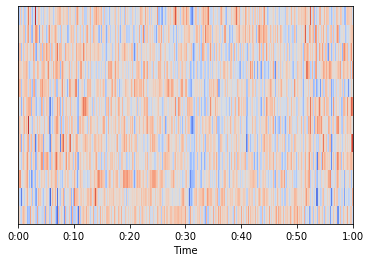

In [4]:
#test to see if what we have extracted make sense
i=40
print("artist: "+x[i]["artist"])
print("song: "+x[i]["song"])
mfcc=x[i]["mfcc"]
print("shape:")
print(mfcc.shape)
#print("means:")
#print(mfcc.mean(axis=0))
#print("var:")
#print(mfcc.var(axis=0))
librosa.display.specshow(mfcc.T, sr=fs, x_axis='time')

artist: Ed Sheeran
song: Runaway
shape:
(704, 12)


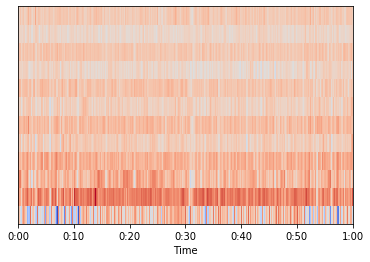

In [6]:
#test to see if what we have extracted make sense
i=40
print("artist: "+x1[i]["artist"])
print("song: "+x1[i]["song"])
mfcc1=x1[i]["mfcc"]
print("shape:")
print(mfcc1.shape)
#print("means:")
#print(mfcc.mean(axis=0))
#print("var:")
#print(mfcc.var(axis=0))
librosa.display.specshow(mfcc1.T, sr=fs, x_axis='time')

### Create Matrix of features and list of labales for trian and test

In [5]:
#select songs to use as train and those to use as test
x_train, x_test= sklearn.model_selection.train_test_split(x, random_state=1)
N_train, N_test= len(x_train),len(x_test) 
print(N_train)
print(N_test)

159
54


In [6]:
#create a big matrix containing all mfcc of all songs of all artists for train and test
features_train=numpy.empty((1,n_mfcc))
for t in x_train:
    features_train=numpy.vstack((features_train, t["mfcc"]))
features_train=numpy.delete(features_train,0,0)

features_test=numpy.empty((1,n_mfcc))
for t in x_test:
    features_test=numpy.vstack((features_test, t["mfcc"]))
features_test=numpy.delete(features_test,0,0)

print(features_train.shape)
print(features_test.shape)

(110157, 12)
(38016, 12)


In [7]:
#creating labels of each frame relative to the artist
artist_labels_train=[]
for t in x_train:
    for _ in range(t["mfcc"].shape[0]):
        artist_labels_train.append(t["artist"])
#print(artist_labels_train)
#print(len(artist_labels_train))

artist_labels_test=[]
for t in x_test:
    for _ in range(t["mfcc"].shape[0]):
        artist_labels_test.append(t["artist"])
#print(artist_labels_test)  
#print(len(artist_labels_test))


In [8]:
#creating also song labels
song_labels_train=[]
for t in x_train:
    for _ in range(t["mfcc"].shape[0]):
        song_labels_train.append(t["song"])
#print(len(song_labels_train))

song_labels_test=[]
for t in x_test:
    for _ in range(t["mfcc"].shape[0]):
        song_labels_test.append(t["song"])
#print(len(song_labels_test))  

## Two step classification of songs to their artists using KNN:
### 1)knn classification of frames to artists
### 2)classification of songs using classified frames


In [9]:
#using knn to classify frames of songs to each artist
#this is a frame-level classification, not a song-level one

k=10 ##num of neighbours, default is 5

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(features_train, artist_labels_train)
artist_labels_pred_knn = knn.predict(features_test)
#confusion matrix for frames
sklearn.metrics.confusion_matrix(artist_labels_test, artist_labels_pred_knn)

array([[1764, 1402,  862,  403, 1086,  834,  689],
       [1471, 2210,  754,  473, 1404, 1273,  863],
       [ 552,  618,  750,  162,  553,  449,  436],
       [ 915,  765,  390,  817,  769,  873,  399],
       [ 573,  702,  340,  166,  928,  494,  317],
       [ 909, 1096,  723,  406, 1208, 2028,  670],
       [ 468,  647,  487,  148,  539,  450,  781]], dtype=int64)

In [10]:
#classify each song to the artist for which the majority of its
#frames have been classified
out_knn={}
for canzone in set(song_labels_test):
    u=[artist_labels_pred_knn[u] for u in range(len(artist_labels_pred_knn)) if song_labels_test[u] == canzone]
    out_knn[canzone]=max(set(u), key=u.count)
#out_knn    

Number of correct predictions: 39
Accuracy: 0.722


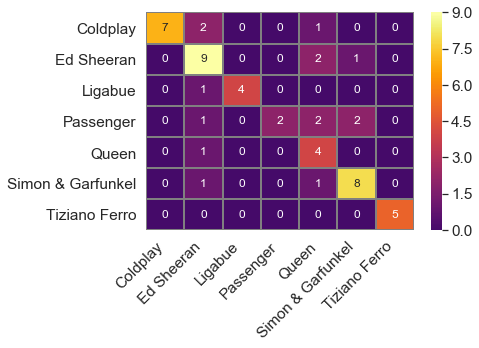

In [54]:
#compute error on the test set for knn procedure
#and create confusion matrix for songs
s=0
for t in x_test:
    if t["artist"]==out_knn[t["song"]]:
        s=s+1
print("Number of correct predictions: "+str(s))
print("Accuracy: "+ str(round(s/N_test,3)))



##create dictioary such that to each artist correspond the list of
##its songs as preddicted by knn two step procedure
song_and_artist_pred_knn={}
for key,value in out_knn.items():
    if value not in song_and_artist_pred_knn:
        song_and_artist_pred_knn[value] = []
    song_and_artist_pred_knn[value].append(key)
#print(song_and_artist_pred_knn)
    
##create dictioary such that to each artist correspond the list of
##its real songs
song_and_artist_test={}
for t in x_test:
    if t["artist"] not in song_and_artist_test:
        song_and_artist_test[t["artist"]] = []
    song_and_artist_test[t["artist"]].append(t["song"])
#print(song_and_artist_test)

##create a list of arstist in the dataset
artistlist=[]
for t in x:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)

##initialize confusion matrix having all zeros and col/row names corresponding to artist
N_art=len(artistlist)
conf_matrix_knn = pandas.DataFrame(numpy.zeros(shape=(N_art,N_art)), columns = artistlist, index=artistlist)

##place in position (i,j) the number of songs from artist i predicted as of artist j
for artist_t, listsong_t in song_and_artist_test.items():
    for artist_p, listsong_p in song_and_artist_pred_knn.items():
        tot=len(set(listsong_t).intersection(listsong_p))
        conf_matrix_knn[artist_p][artist_t]=tot
#confusion matrix as plotted by pandas
#conf_matrix_knn.astype(int)

#nice heatmap
seaborn.set(font_scale=1.4)
seaborn.heatmap(conf_matrix_knn, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="inferno",center=3.3)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

## Two step classification of songs to their artists using Decison Tree:
### 1)tree classification of frames to artists
### 2)classification of songs using classified frames

In [47]:
#using a Decision Tree to classify frames of songs to each artist
#this is a frame-level classification, not a song-level one
clf = sklearn.tree.DecisionTreeClassifier()
clf = clf.fit(features_train, artist_labels_train)
artist_labels_pred_tree = clf.predict(features_test)
#confusion matrix for frames
sklearn.metrics.confusion_matrix(artist_labels_test, artist_labels_pred_tree)

array([[1152, 1139,  982,  606, 1244,  977,  940],
       [1130, 1426, 1027,  691, 1467, 1500, 1207],
       [ 434,  509,  628,  272,  608,  555,  514],
       [ 682,  669,  491,  688,  811, 1012,  575],
       [ 426,  546,  436,  234,  780,  626,  472],
       [ 804,  967,  786,  603, 1191, 1762,  927],
       [ 425,  503,  513,  215,  599,  562,  703]], dtype=int64)

In [48]:
#classify each song to the artist for which the majority of its
#frames have been classified
out_tree={}
for canzone in set(song_labels_test):
    u=[artist_labels_pred_tree[u] for u in range(len(artist_labels_pred_tree)) if song_labels_test[u] == canzone]
    out_tree[canzone]=max(set(u), key=u.count)
#out_tree 

Number of correct predictions: 26
Accuracy: 0.481


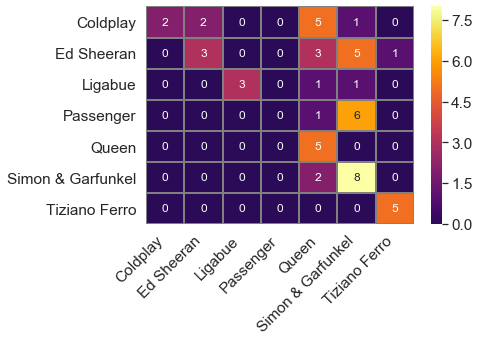

In [53]:
#compute error on the test set for knn procedure
#and create confusion matrix for songs
s=0
for t in x_test:
    if t["artist"]==out_tree[t["song"]]:
        s=s+1
print("Number of correct predictions: "+str(s))
print("Accuracy: "+ str(round(s/N_test,3)))



##create dictioary such that to each artist correspond the list of
##its songs as preddicted by knn two step procedure
song_and_artist_pred_tree={}
for key,value in out_tree.items():
    if value not in song_and_artist_pred_tree:
        song_and_artist_pred_tree[value] = []
    song_and_artist_pred_tree[value].append(key)
#print(song_and_artist_pred_knn)
    
##create dictioary such that to each artist correspond the list of
##its real songs
song_and_artist_test={}
for t in x_test:
    if t["artist"] not in song_and_artist_test:
        song_and_artist_test[t["artist"]] = []
    song_and_artist_test[t["artist"]].append(t["song"])
#print(song_and_artist_test)

##create a list of artist in the dataset
artistlist=[]
for t in x:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)

##initialize confusion matrix having all zeros and col/row names corresponding to artist
N_art=len(artistlist)
conf_matrix_tree = pandas.DataFrame(numpy.zeros(shape=(N_art,N_art)), columns = artistlist, index=artistlist)

##place in position (i,j) the number of songs from artist i predicted as of artist j
for artist_t, listsong_t in song_and_artist_test.items():
    for artist_p, listsong_p in song_and_artist_pred_tree.items():
        tot=len(set(listsong_t).intersection(listsong_p))
        conf_matrix_tree[artist_p][artist_t]=tot
        
#nice heatmap done with the confusion matrix
seaborn.set(font_scale=1.4)
seaborn.heatmap(conf_matrix_tree, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="inferno",center=3.3)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### Prepare data for Visualization

In [49]:
##############################################
#####data for PCA visualization at frame level
##############################################

###create a matrix with all frames of all songs
all_mfcc=numpy.empty((1,n_mfcc))
for t in x1:
    all_mfcc=numpy.vstack((all_mfcc, t["mfcc"]))
all_mfcc=numpy.delete(all_mfcc,0,0)
scaler = sklearn.preprocessing.StandardScaler()
all_mfcc=scaler.fit_transform(all_mfcc)

###create a list of corresponding labels and convert to pandas df
all_labels=[]
for t in x1:
    for _ in range(t["mfcc"].shape[0]):
        all_labels.append(t["artist"])
all_labels=pandas.DataFrame(all_labels, columns = ["artist"])
#all_labels

#create data frame with first two pc and artist label for the mfccs of all frames
PCA = sklearn.decomposition.PCA(n_components=2)
mfcc_principalComponents = PCA.fit_transform(all_mfcc)
mfcc_principalComponents = pandas.DataFrame(data = mfcc_principalComponents, columns = ['pc1', 'pc2'])
df_frames = pandas.concat([mfcc_principalComponents, all_labels],axis=1)
#df_frames

In [50]:
##############################################
######data for PCA visualization at song level
##############################################

#for each song take the average of their mfccs along all its frames
song_mfcc=numpy.empty((1,n_mfcc))
for t in x1:
    song_mfcc=numpy.vstack((song_mfcc, t["mfcc"].sum(axis=0)))
song_mfcc=numpy.delete(song_mfcc,0,0)
scaler = sklearn.preprocessing.StandardScaler()
song_mfcc=scaler.fit_transform(song_mfcc)


#create a label with artist for the above averages
song_labels=[]
for t in x1:
    song_labels.append(t["artist"])
song_labels=pandas.DataFrame(song_labels, columns = ["artist"])

#create data frame with first two pc and artist label for the mfccs of all frames
PCA = sklearn.decomposition.PCA(n_components=2)
mfcc_avg_principalComponents = PCA.fit_transform(song_mfcc)
mfcc_avg_principalComponents = pandas.DataFrame(data = mfcc_avg_principalComponents, columns = ['pc1', 'pc2'])
df_song = pandas.concat([mfcc_avg_principalComponents, song_labels],axis=1)
#df_song


In [110]:
###############################################
######data for LDA visualization at frame level
###############################################
#we tranform data according to LDA using just train data
#and then visualize in the space of the first two dicriminant variables
#both train and test data

###split train/test unormalized mfccs (or better normalized glibally not song by song)

#prepare
all_mfcc=numpy.empty((1,n_mfcc))
all_labels=[]
for t in x1:
    all_mfcc=numpy.vstack((all_mfcc, t["mfcc"]))
    for _ in range(t["mfcc"].shape[0]):
        all_labels.append(t["artist"])
all_mfcc=numpy.delete(all_mfcc,0,0)
all_mfcc=scaler.fit_transform(all_mfcc)

#split
x1_train, x1_test, all_labels_train, all_labels_test=sklearn.model_selection.train_test_split(all_mfcc,all_labels, random_state=1)


###lda
lda=sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
lda_train = lda.fit_transform(x1_train, all_labels_train)
lda_test = lda.transform(x1_test)
lda=numpy.vstack((lda_train, lda_test))
frame_labels_lda=all_labels_train+all_labels_test
lda=pandas.DataFrame(data = lda, columns = ['ldv1', 'ldv2'])
frame_labels_lda=pandas.DataFrame(frame_labels_lda, columns = ["artist"])
df_frames_lda = pandas.concat([lda, frame_labels_lda],axis=1)
#df_frames_lda

In [111]:
###############################################
#######data for LDA visualization at song level
###############################################




### Frame-Level Visualization of first two PC

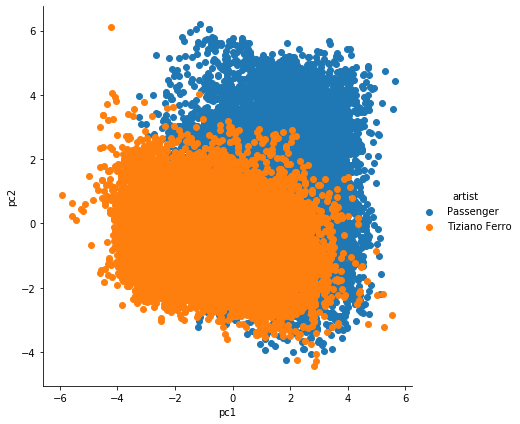

In [99]:
###RUN code to get data for this visualization before visualizing
###because the differt kind of visualization may have conflicting names


#manual way
"""fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of Frames', fontsize = 20)

targets = artistlist
colors = ['r','g','b','c','m','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = df_frames['artist'] == target
    ax.scatter(df_frames.loc[indicesToKeep, 'pc1']
               , df_frames.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50
               , alpha=0.5)
ax.legend(targets)
ax.grid()"""



#alternative one line code
#filter to show only desidered artists. to show all use artistlist in place of printlist
#artist are 'Coldplay','Ed Sheeran','Ligabue','Passenger','Queen','Simon & Garfunkel','Tiziano Ferro'
printlist=['Passenger','Tiziano Ferro']
seaborn.FacetGrid(df_frames[df_frames.artist.isin(printlist)],
                  hue="artist", size=6).map(plt.scatter, "pc1", "pc2").add_legend()

### Song-Level Visualization of first two PC

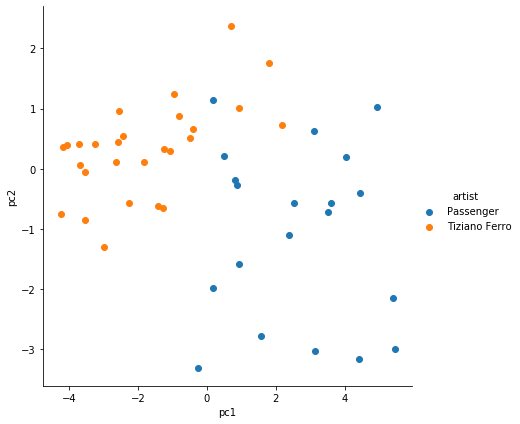

In [72]:
###RUN code to get data for this visualization before visualizing
###because the differt kind of visualization may have conflicting names

"""fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of songs', fontsize = 20)

targets = artistlist
colors = ['r','g','b','c','m','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = df_song['artist'] == target
    ax.scatter(df_song.loc[indicesToKeep, 'pc1']
               , df_song.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50
               , alpha=0.8)
ax.legend(targets)
ax.grid()
"""

#alternative one line code
#filter to show only desidered artists. to show all use artistlist in place of printlist
#artist are 'Coldplay','Ed Sheeran','Ligabue','Passenger','Queen','Simon & Garfunkel','Tiziano Ferro'
printlist=['Passenger','Tiziano Ferro']
seaborn.FacetGrid(df_song[df_song.artist.isin(printlist)],
                  hue="artist", size=6).map(plt.scatter, "pc1", "pc2").add_legend()


### Frame-Level visualization using first two LD variables

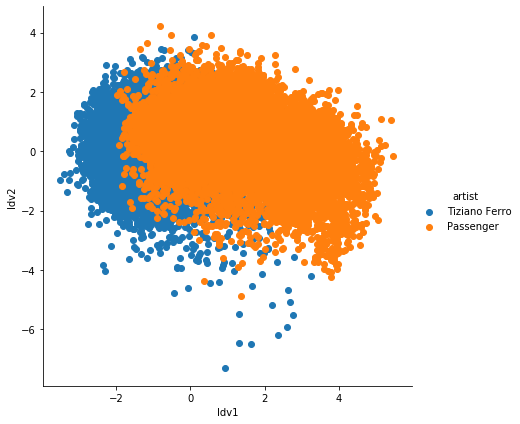

In [109]:
###RUN code to get data for this visualization before visualizing
###because the differt kind of visualization may have conflicting names

#filter to show only desidered artists. to show all use artistlist in place of printlist
#artist are 'Coldplay','Ed Sheeran','Ligabue','Passenger','Queen','Simon & Garfunkel','Tiziano Ferro'
printlist=['Passenger','Tiziano Ferro']
seaborn.FacetGrid(df_frames_lda[df_frames_lda.artist.isin(printlist)],
                  hue="artist", size=6).map(plt.scatter, "ldv1", "ldv2").add_legend()